In [1]:
# Fix PTLFlow CLI compatibility (Lightning version)
import sys
import subprocess

subprocess.run([sys.executable, "-m", "pip", "install", "-U", "lightning<2.2"], check=True)

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


CompletedProcess(args=['/data0/guojia/miniconda3/envs/ptlflow/bin/python', '-m', 'pip', 'install', '-U', 'lightning<2.2'], returncode=0)

/data0/guojia/miniconda3/envs/ptlflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data0/guojia/miniconda3/envs/ptlflow/lib/python3.12/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/data0/guojia/miniconda3/envs/ptlflow/lib/python3.12/site-packages/lightning/fabric/__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


[!!alt_cuda_corr is not compiled!!]


xFormers not available
xFormers not available


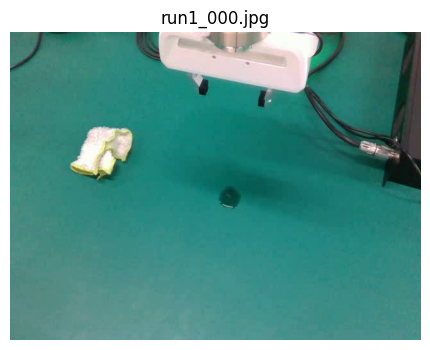

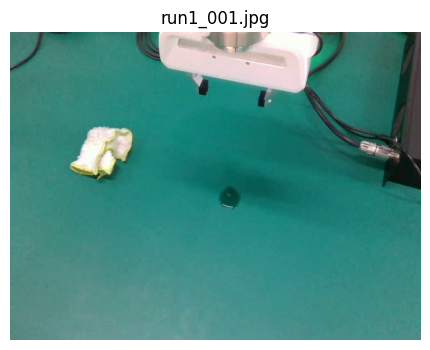

/data0/guojia/work_huang/ptlflow/ptlflow/data/flow_transforms.py:142: SyntaxWarning: invalid escape sequence '\|'
  In other words, a pixel p is considered occluded when \|Ff(p) + Fb(p + F(f))\|_2 > threshold,
/data0/guojia/work_huang/ptlflow/ptlflow/data/flow_transforms.py:160: SyntaxWarning: invalid escape sequence '\|'
  A pixel is considered occluded if \|Ff(p) + Fb(p + F(f))\|_2 > threshold.
Downloading: "https://github.com/hmorimitsu/ptlflow/releases/download/weights1/raft_small-things-b7d9f997.ckpt" to /home/guojia/.cache/torch/hub/checkpoints/raft_small-things-b7d9f997.ckpt
100%|██████████| 3.81M/3.81M [00:01<00:00, 2.45MB/s]
2026-02-06 11:54:00.131 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


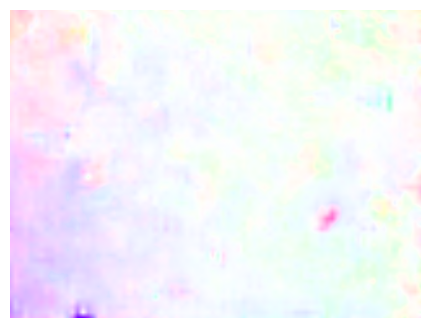

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"
os.environ["ALL_PROXY"] = "socks5h://127.0.0.1:1080"
os.environ["HTTP_PROXY"] = os.environ["ALL_PROXY"]
os.environ["HTTPS_PROXY"] = os.environ["ALL_PROXY"]

import sys
from pathlib import Path
import urllib.request

import ptlflow
import cv2 as cv
import matplotlib.pyplot as plt

# Download two images to serve as inputs to the optical flow model
base_url = "https://raw.githubusercontent.com/zhou1013mm/sam3/main"
for name in ("run1_000.jpg", "run1_005.jpg"):
    url = f"{base_url}/{name}"
    if not Path(name).exists():
        urllib.request.urlretrieve(url, name)

def show_bgr(img, title=None):
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 4))
    if title:
        plt.title(title)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

show_bgr(cv.imread("run1_000.jpg"), "run1_000.jpg")
show_bgr(cv.imread("run1_005.jpg"), "run1_005.jpg")

# Additional dependencies for this example
from ptlflow.utils.io_adapter import IOAdapter
from ptlflow.utils import flow_utils

# Load the two images
img1 = cv.imread("run1_000.jpg")
img2 = cv.imread("run1_005.jpg")

# Get an initialized model from PTLFlow
model = ptlflow.get_model("raft_small", ckpt_path="things")
model.eval()

# IOAdapter is a helper to transform the two images into the input format accepted by PTLFlow models
io_adapter = IOAdapter(model, img1.shape[:2])
inputs = io_adapter.prepare_inputs([img1, img2])

# Forward the inputs to obtain the model predictions
predictions = model(inputs)

# Visualize and save the predicted flow
flow = predictions["flows"][0, 0]  # Remove batch and sequence dimensions
flow = flow.permute(1, 2, 0)  # change from CHW to HWC shape
flow = flow.detach().cpu().numpy()
flow_viz = flow_utils.flow_to_rgb(flow)  # Represent the flow as RGB colors
flow_viz = cv.cvtColor(flow_viz, cv.COLOR_BGR2RGB)  # OpenCV uses BGR format
out_path = Path("outputs") / "raft_small_flow_run1_005.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
cv.imwrite(str(out_path), cv.cvtColor(flow_viz, cv.COLOR_RGB2BGR))

plt.figure(figsize=(6, 4))
plt.imshow(flow_viz)
plt.axis("off")
plt.show()